In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

# 1、访问和读取数据集

In [2]:
train_data = pd.read_csv(d2l.download('kaggle_house_train'))
test_data = pd.read_csv(d2l.download('kaggle_house_test'))

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [4]:
print(train_data.iloc[0:5,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
4   5          60       RL         84.0       WD        Normal     250000


In [5]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
all_features.shape

(2919, 79)

# 2、数据预处理 

In [6]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [7]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [8]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels=torch.tensor(
    train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

# 3、训练

In [9]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net



In [10]:
def log_rmse(net,features,labels):
    clipped_pred = torch.clamp(net(features),1,float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_pred),torch.log(labels)))
    
    return rmse.item()

In [11]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    train_iter =  d2l.load_array((train_features,train_labels),batch_size)
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay = weight_decay)
    
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

# 4、k折交叉验证 

In [12]:
def get_k_fold_data(k,i,X,y):
    assert k >1
    fold_size = X.shape[0] // k 
    X_train,y_train = None,None
    
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        if j==i:
            X_valid,y_vaid = X_part,y_part
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            X_train = torch.cat([X_train,X_part],0)
            y_train = torch.cat([y_train,y_part],0)
    return X_train,y_train,X_valid,y_vaid        

In [13]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net()
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],legend = ['train','valid'],yscale='log')
        print(f'折{i+1}，训练log rmse{float(train_ls[-1]):f},'
             f'验证log rmse{float(valid_ls[-1]):f}')
        
    return train_l_sum /k,valid_l_sum/k

# 5、模型选择 

折1，训练log rmse0.169827,验证log rmse0.157000
折2，训练log rmse0.162255,验证log rmse0.191488
折3，训练log rmse0.163762,验证log rmse0.168287
折4，训练log rmse0.167628,验证log rmse0.154365
折5，训练log rmse0.163838,验证log rmse0.183165
5-折验证：平均训练log rmse:0.165462,平均验证log rmse:0.170861


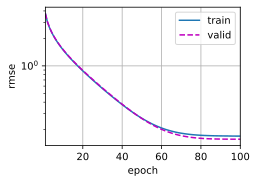

In [14]:
k,num_epochs,lr,weight_decay,batch_size = 5, 100, 5, 0, 64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证：平均训练log rmse:{float(train_l):f},'
     f'平均验证log rmse:{float(valid_l):f}')

# 6、提交kaggle预测

In [15]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162487


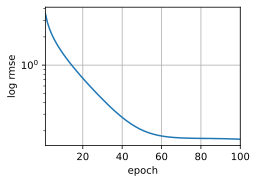

In [16]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)